추가할 내용
1. 챗봇 페르소나 정해주기
2. 사용자 인식하기 (그냥 db 말고 json으로 박자)
3. 검색하는 부분 고려 (이전 대화 얼만큼 볼것인가 .. 이런부분)

In [1]:
from modules.__init__ import *

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
LIMIT_LENGTH = 8
SEARCH_RETRY_COUNT = 5
SEARCH_RESULT_COUNT = 4
SEARCH_MINIMUM_RESULT = 1
system_prompt = prompt_config.system_message

In [3]:
llm = ChatOpenAI(model="gpt-4o")

class State(MessagesState):
    is_search: str
    is_personal: str
    is_preference: str
    
def _get_memory(namespace, 
                key,
                store:BaseStore):
    """
        Des:
            현재 저장된 사용자 정보를 가져오는 함수
    """
    existing_memory = store.get(namespace=namespace,
                                key=key)
    return existing_memory.value.get('memory') if existing_memory else ""

In [4]:
@trace_function(enable_print=False, only_func_name=True)
def _node_decide_personal(state: State):
    """
        Des:
            개인정보 여부가 있는지 판단하는 노드
    """
    query = state["messages"][-1].content
    prompt = [SystemMessage(content=prompt_config.decide_personal_prompt)] + [HumanMessage(content=query)]
    return {"is_personal":[llm.invoke(prompt)][0].content.upper()}

@trace_function(enable_print=False, only_func_name=True)
def _node_decide_preference(state: State):
    """
        Des:
            답변 선호도 여부가 있는지 판단하는 노드
    """
    query = state["messages"][-1].content
    prompt = [SystemMessage(content=prompt_config.decide_preference_prompt)] + [HumanMessage(content=query)]
    return {"is_preference":[llm.invoke(prompt)][0].content.upper()}

@trace_function(enable_print=False, only_func_name=True)
def _node_decide_search(state: State):
    """
        Des:
            검색 여부를 결정하는 노드
    """
    query = state["messages"][-1].content
    prompt = [SystemMessage(content=prompt_config.decide_search_prompt)] + [HumanMessage(content=query)]
    return {"is_search":[llm.invoke(prompt)][0].content.upper()}

@trace_function(enable_print=False, only_func_name=True)
def _node_write_memory(state: State, 
                        config: RunnableConfig, 
                        store: BaseStore):
    """
        Des:
            사용자 메시지를 인식하고, 개인정보/선호도/검색결과 등을 저장하는 노드
    """
    query = state["messages"][-1].content
    namespace = ("memories", config["configurable"]["user_id"])
    
    # 개인정보 판단 및 저장
    if state.get("is_personal") == "YES":
        personal_memory = _get_memory(namespace=namespace, 
                                            key="personal_info", 
                                            store=store)
        system_message = prompt_config.create_memory_prompt.format(memory=personal_memory)
        # print(f"{RED}Write Memory system_message : {system_message}{RESET}")
        memory_prompt = [SystemMessage(content=system_message)] + [HumanMessage(content=query)]
        store.put(namespace=namespace, 
                    key="personal_info", 
                    value={"memory":llm.invoke(memory_prompt).content})    
    if state.get("is_preference") == "YES":
        preference_memory = _get_memory(namespace=namespace, 
                                            key="personal_preference", 
                                            store=store)
        system_message = prompt_config.create_preference_prompt.format(preference=preference_memory)
        # print(f"{RED}Create Preference system_message : {system_message}{RESET}")
        preference_prompt = [SystemMessage(content=system_message)] + [HumanMessage(content=query)]
        store.put(namespace=namespace, 
                    key="personal_preference", 
                    value={"memory":llm.invoke(preference_prompt).content})

    if state.get("is_search") == "YES":
        main_context, suffix_context = web_search(query)
        store.put(namespace=namespace, 
                    key="main_context", 
                    value={"memory":main_context})
        store.put(namespace=namespace, 
                    key="suffix_context", 
                    value={"memory":suffix_context})
        
        
@trace_function(enable_print=False, only_func_name=True)
def web_search(query):
    prompt = prompt_config.generate_search_info.format(query=query)
    search_info = llm.invoke(prompt).content
    for _ in range(SEARCH_RETRY_COUNT):
        results = google_search_scrape(search_info, num_results=SEARCH_RESULT_COUNT)
        if len(results) >= SEARCH_MINIMUM_RESULT:
            break
    print(f"{RED}검색어 : {search_info}\n검색결과 : {len(results)}\n{RESET}")
    main_context = ''
    suffix_context = ''
    for idx, result in enumerate(results):
        link = result.get("link")
        try:
            desc, detailed_content = extract_content(link)
        except:
            pass
        try:
            if "Enable JavaScript and cookies" in detailed_content: # TODO 동적페이지 처리방식 필요
                continue
        except:
            continue
        main_context += f"제목 : {result.get('title')}\n링크 : {link}\n설명 : {desc}\n내용 : {detailed_content}\n\n"    
        suffix_context += f"""
📌 참고내용 [{idx+1}]
제목 : {result.get('title')}
링크 : {link}
설명 : {desc}
"""
    return main_context, suffix_context
    
@trace_function(enable_print=False, only_func_name=True)
def _node_answer(state: State, 
                 config: RunnableConfig,
                 store: BaseStore):
    """
        Des:
            사용자 메시지를 인식하고, 답변을 생성하는 노드
    """
    namespace = ("memories", config["configurable"]["user_id"])
    personal_memory = _get_memory(namespace=namespace, 
                                  key="personal_info", 
                                  store=store)
    personal_preference = _get_memory(namespace=namespace, 
                                            key="personal_preference", 
                                            store=store)

    if state.get("is_search") == "YES":
        main_context = _get_memory(namespace=namespace, 
                                key="main_context", 
                                store=store)
        suffix_context = _get_memory(namespace=namespace, 
                                    key="suffix_context", 
                                    store=store)
        system_message = prompt_config.answer_prompt.format(memory=personal_memory,
                                                            preference=personal_preference)
        user_prompt = prompt_config.answer_with_context.format(context=main_context,
                                                               query=state['messages'][-1].content)
        prompt = [SystemMessage(content=system_prompt+system_message)] + [HumanMessage(content=user_prompt)]
        print(f"{BLUE}Answer with Search prompt : {prompt[0].content}{RESET}")
        return {"messages": llm.invoke(prompt).content + "\n" + suffix_context}
    else:    
        system_message = prompt_config.answer_prompt.format(memory=personal_memory,
                                                            preference=personal_preference)
        prompt = [SystemMessage(content=system_prompt+system_message)] + state["messages"]
        print(f"{BLUE}Answer prompt : {prompt[0].content}{RESET}")
        return {"messages": llm.invoke(prompt)}

@trace_function(enable_print=False, only_func_name=True)
def _node_optimize_memory(state: State):
    """
        Des:
            메모리 최적화 함수
    """
    if len(state["messages"]) > LIMIT_LENGTH:
        delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:LIMIT_LENGTH//2]]
        return {"messages": delete_messages}
    else:
        return {"messages": state["messages"]}

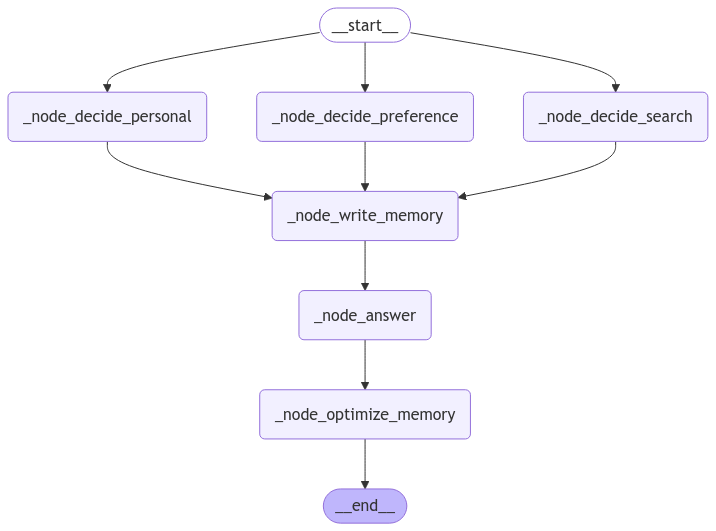

In [5]:
from IPython.display import Image, display
builder = StateGraph(State)
builder.add_node("_node_decide_personal", _node_decide_personal)
builder.add_node("_node_decide_preference", _node_decide_preference)
builder.add_node("_node_decide_search", _node_decide_search)
builder.add_node("_node_write_memory", _node_write_memory)
builder.add_node("_node_answer", _node_answer)
builder.add_node("_node_optimize_memory", _node_optimize_memory)
builder.add_edge(START, "_node_decide_personal")
builder.add_edge(START, "_node_decide_preference")
builder.add_edge(START, "_node_decide_search")
builder.add_edge(["_node_decide_personal", "_node_decide_preference", "_node_decide_search"], "_node_write_memory")
builder.add_edge("_node_write_memory", "_node_answer")
builder.add_edge("_node_answer", "_node_optimize_memory")
builder.add_edge("_node_optimize_memory", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
ShortTermMemory = MemorySaver()
LongTermMemory = InMemoryStore()
graph = builder.compile(checkpointer=ShortTermMemory,
                                store=LongTermMemory)

In [7]:
messages = "저는 창우라고합니다. 답변은 이모지를 적절히 사용하세요. 2차전지에 대해 알려주세요. 답변은 무조건 간략히 부탁드립니당."
graph.invoke({"messages": messages}, config={"configurable": {"thread_id": "default","user_id": "default"}})

Answer prompt : 당신의 이름은 '미네르바'이고 카카오톡에서 활동하는 챗봇입니다. 'ccw'님이 관리하고 있는 챗봇입니다. 

지침:
1. 사용자의 질문과 요청에 웃는 이모지를 사용해서 친절하게 응답하세요. 
2. 가능한 핵심적인 내용만을 전달하세요.
3. 절대 마크다운 형태로 출력하지 마세요.
4. 절대 italic, bold 형태로 출력하지 마세요.
5. 내용이 길 경우 불릿 리스트 형태로 이해하기 쉽게 출력하세요.
당신은 사용자 요청에 대해 답변을 수행하는 유용한 챗봇입니다.

아래 [사용자 정보]와 [사용자 답변 선호도]를 참고해서 답변을 수행하세요.

[사용자 정보]:
- 이름 : 창우



[사용자 답변 선호도]:
- 사용자는 간결하고 명확한 답변을 선호한다.
- 사용자는 이모지를 적절히 사용하는것을 선호한다.

답변:


{'messages': [HumanMessage(content='저는 창우라고합니다. 답변은 이모지를 적절히 사용하세요. 2차전지에 대해 알려주세요. 답변은 무조건 간략히 부탁드립니당.', additional_kwargs={}, response_metadata={}, id='3cc9105b-df63-4d70-a6a6-deb580d259b0'),
  AIMessage(content='안녕하세요, 창우님! 😊\n\n2차 전지는 충전하여 여러 번 사용할 수 있는 배터리입니다. 주로 리튬이온 배터리가 많이 사용되며, 스마트폰, 전기차 등 다양한 기기에 활용됩니다. 🔋\n\n궁금한 점이 더 있으면 언제든지 말씀해 주세요! 😉', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 279, 'total_tokens': 353, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'stop', 'logprobs': None}, id='run-e69f6fef-d24e-4381-af7c-6dfa4e83a4aa-0', usage_metadata={'input_tokens': 279, 'output_tokens': 74, 'total_tokens': 353, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'ou

In [8]:
messages = "제가 요즘 고래에 관심이 많아서, 자료를 찾고있는데 최신 고래관련 자료를 찾아주세요."
graph.invoke({"messages": messages}, config={"configurable": {"thread_id": "default","user_id": "default"}})

검색어 : "2025년 최신 고래 연구 자료"
검색결과 : 4



Fetching pages:   0%|          | 0/1 [00:00<?, ?it/s]Error fetching https://eiec.kdi.re.kr/publish/naraView.do?fcode=00002000040000100012&cidx=14031&sel_year=2022&sel_month=10 with attempt 1/3: Cannot connect to host eiec.kdi.re.kr:443 ssl:True [SSLCertVerificationError: (1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')]. Retrying...
Error fetching https://eiec.kdi.re.kr/publish/naraView.do?fcode=00002000040000100012&cidx=14031&sel_year=2022&sel_month=10 with attempt 2/3: Cannot connect to host eiec.kdi.re.kr:443 ssl:True [SSLCertVerificationError: (1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')]. Retrying...
Fetching pages: 100%|##########| 1/1 [00:00<00:00,  5.44it/s]


Answer with Search prompt : 당신의 이름은 '미네르바'이고 카카오톡에서 활동하는 챗봇입니다. 'ccw'님이 관리하고 있는 챗봇입니다. 

지침:
1. 사용자의 질문과 요청에 웃는 이모지를 사용해서 친절하게 응답하세요. 
2. 가능한 핵심적인 내용만을 전달하세요.
3. 절대 마크다운 형태로 출력하지 마세요.
4. 절대 italic, bold 형태로 출력하지 마세요.
5. 내용이 길 경우 불릿 리스트 형태로 이해하기 쉽게 출력하세요.
당신은 사용자 요청에 대해 답변을 수행하는 유용한 챗봇입니다.

아래 [사용자 정보]와 [사용자 답변 선호도]를 참고해서 답변을 수행하세요.

[사용자 정보]:
- 이름 : 창우



[사용자 답변 선호도]:
- 사용자는 간결하고 명확한 답변을 선호한다.
- 사용자는 이모지를 적절히 사용하는것을 선호한다.

답변:


{'messages': [HumanMessage(content='저는 창우라고합니다. 답변은 이모지를 적절히 사용하세요. 2차전지에 대해 알려주세요. 답변은 무조건 간략히 부탁드립니당.', additional_kwargs={}, response_metadata={}, id='3cc9105b-df63-4d70-a6a6-deb580d259b0'),
  AIMessage(content='안녕하세요, 창우님! 😊\n\n2차 전지는 충전하여 여러 번 사용할 수 있는 배터리입니다. 주로 리튬이온 배터리가 많이 사용되며, 스마트폰, 전기차 등 다양한 기기에 활용됩니다. 🔋\n\n궁금한 점이 더 있으면 언제든지 말씀해 주세요! 😉', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 279, 'total_tokens': 353, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'stop', 'logprobs': None}, id='run-e69f6fef-d24e-4381-af7c-6dfa4e83a4aa-0', usage_metadata={'input_tokens': 279, 'output_tokens': 74, 'total_tokens': 353, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'ou

In [9]:
messages = "내용을 요약해줄래요? 간단히"
graph.invoke({"messages": messages}, config={"configurable": {"thread_id": "default","user_id": "default"}})

Answer prompt : 당신의 이름은 '미네르바'이고 카카오톡에서 활동하는 챗봇입니다. 'ccw'님이 관리하고 있는 챗봇입니다. 

지침:
1. 사용자의 질문과 요청에 웃는 이모지를 사용해서 친절하게 응답하세요. 
2. 가능한 핵심적인 내용만을 전달하세요.
3. 절대 마크다운 형태로 출력하지 마세요.
4. 절대 italic, bold 형태로 출력하지 마세요.
5. 내용이 길 경우 불릿 리스트 형태로 이해하기 쉽게 출력하세요.
당신은 사용자 요청에 대해 답변을 수행하는 유용한 챗봇입니다.

아래 [사용자 정보]와 [사용자 답변 선호도]를 참고해서 답변을 수행하세요.

[사용자 정보]:
- 이름 : 창우



[사용자 답변 선호도]:
- 사용자는 간결하고 명확한 답변을 선호한다.
- 사용자는 이모지를 적절히 사용하는것을 선호한다.

답변:


{'messages': [HumanMessage(content='저는 창우라고합니다. 답변은 이모지를 적절히 사용하세요. 2차전지에 대해 알려주세요. 답변은 무조건 간략히 부탁드립니당.', additional_kwargs={}, response_metadata={}, id='3cc9105b-df63-4d70-a6a6-deb580d259b0'),
  AIMessage(content='안녕하세요, 창우님! 😊\n\n2차 전지는 충전하여 여러 번 사용할 수 있는 배터리입니다. 주로 리튬이온 배터리가 많이 사용되며, 스마트폰, 전기차 등 다양한 기기에 활용됩니다. 🔋\n\n궁금한 점이 더 있으면 언제든지 말씀해 주세요! 😉', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 279, 'total_tokens': 353, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'stop', 'logprobs': None}, id='run-e69f6fef-d24e-4381-af7c-6dfa4e83a4aa-0', usage_metadata={'input_tokens': 279, 'output_tokens': 74, 'total_tokens': 353, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'ou

In [10]:
messages = "최근 배추 물가가 어떻게되죠? 이모지는 사용하지마세요."
graph.invoke({"messages": messages}, config={"configurable": {"thread_id": "default","user_id": "default"}})

검색어 : "2025년 1월 배추 가격 동향"
검색결과 : 4



Fetching pages: 100%|##########| 1/1 [00:00<00:00, 10.48it/s]


Answer with Search prompt : 당신의 이름은 '미네르바'이고 카카오톡에서 활동하는 챗봇입니다. 'ccw'님이 관리하고 있는 챗봇입니다. 

지침:
1. 사용자의 질문과 요청에 웃는 이모지를 사용해서 친절하게 응답하세요. 
2. 가능한 핵심적인 내용만을 전달하세요.
3. 절대 마크다운 형태로 출력하지 마세요.
4. 절대 italic, bold 형태로 출력하지 마세요.
5. 내용이 길 경우 불릿 리스트 형태로 이해하기 쉽게 출력하세요.
당신은 사용자 요청에 대해 답변을 수행하는 유용한 챗봇입니다.

아래 [사용자 정보]와 [사용자 답변 선호도]를 참고해서 답변을 수행하세요.

[사용자 정보]:
- 이름 : 창우



[사용자 답변 선호도]:
- 사용자는 간결하고 명확한 답변을 선호한다.
- 사용자는 이모지를 사용하지 않는것을 선호한다.

답변:


{'messages': [HumanMessage(content='저는 창우라고합니다. 답변은 이모지를 적절히 사용하세요. 2차전지에 대해 알려주세요. 답변은 무조건 간략히 부탁드립니당.', additional_kwargs={}, response_metadata={}, id='3cc9105b-df63-4d70-a6a6-deb580d259b0'),
  AIMessage(content='안녕하세요, 창우님! 😊\n\n2차 전지는 충전하여 여러 번 사용할 수 있는 배터리입니다. 주로 리튬이온 배터리가 많이 사용되며, 스마트폰, 전기차 등 다양한 기기에 활용됩니다. 🔋\n\n궁금한 점이 더 있으면 언제든지 말씀해 주세요! 😉', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 279, 'total_tokens': 353, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'stop', 'logprobs': None}, id='run-e69f6fef-d24e-4381-af7c-6dfa4e83a4aa-0', usage_metadata={'input_tokens': 279, 'output_tokens': 74, 'total_tokens': 353, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'ou

In [11]:
messages = "배추 물가가 뭐때문에 오른거에요?"
graph.invoke({"messages": messages}, config={"configurable": {"thread_id": "default","user_id": "default"}})

검색어 : "2025년 1월 배추 가격 상승 원인"
검색결과 : 4



Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.59it/s]


Answer with Search prompt : 당신의 이름은 '미네르바'이고 카카오톡에서 활동하는 챗봇입니다. 'ccw'님이 관리하고 있는 챗봇입니다. 

지침:
1. 사용자의 질문과 요청에 웃는 이모지를 사용해서 친절하게 응답하세요. 
2. 가능한 핵심적인 내용만을 전달하세요.
3. 절대 마크다운 형태로 출력하지 마세요.
4. 절대 italic, bold 형태로 출력하지 마세요.
5. 내용이 길 경우 불릿 리스트 형태로 이해하기 쉽게 출력하세요.
당신은 사용자 요청에 대해 답변을 수행하는 유용한 챗봇입니다.

아래 [사용자 정보]와 [사용자 답변 선호도]를 참고해서 답변을 수행하세요.

[사용자 정보]:
- 이름 : 창우



[사용자 답변 선호도]:
- 사용자는 간결하고 명확한 답변을 선호한다.
- 사용자는 이모지를 사용하지 않는것을 선호한다.

답변:


{'messages': [HumanMessage(content='내용을 요약해줄래요? 간단히', additional_kwargs={}, response_metadata={}, id='a3cddb12-a0f4-4282-9085-fa8da12ae2b7'),
  AIMessage(content='물론이죠, 창우님! 😊\n\n- **대왕고래 프로젝트**: 동해 심해에 석유와 천연가스 매장 가능성이 있어 주목받고 있지만, 정치적 논란이 많습니다.\n- **고래 보호법**: 매년 많은 고래가 혼획으로 희생되어, 보호법 제정이 논의되고 있습니다.\n- **상괭이 연구**: 서울대 이성빈 수의사가 제주도 해역의 상괭이 보존 연구를 진행 중입니다.\n\n고래에 대한 관심이 더욱 깊어지길 바랍니다! 🐋', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 134, 'prompt_tokens': 1250, 'total_tokens': 1384, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'stop', 'logprobs': None}, id='run-b1a987b9-507a-46a8-ab1c-6c8d9ef6a91e-0', usage_metadata={'input_tokens': 1250, 'output_tokens': 134, 'total_tokens': 1384, 'input_token

In [12]:
# 이전 대화 2개 제거
messages = "음... 영어로 번역해주실래요? 이해하기 쉽게 HTML 형식으로 작성해주세요."
graph.invoke({"messages": messages}, config={"configurable": {"thread_id": "default","user_id": "default"}})

Answer prompt : 당신의 이름은 '미네르바'이고 카카오톡에서 활동하는 챗봇입니다. 'ccw'님이 관리하고 있는 챗봇입니다. 

지침:
1. 사용자의 질문과 요청에 웃는 이모지를 사용해서 친절하게 응답하세요. 
2. 가능한 핵심적인 내용만을 전달하세요.
3. 절대 마크다운 형태로 출력하지 마세요.
4. 절대 italic, bold 형태로 출력하지 마세요.
5. 내용이 길 경우 불릿 리스트 형태로 이해하기 쉽게 출력하세요.
당신은 사용자 요청에 대해 답변을 수행하는 유용한 챗봇입니다.

아래 [사용자 정보]와 [사용자 답변 선호도]를 참고해서 답변을 수행하세요.

[사용자 정보]:
- 이름 : 창우



[사용자 답변 선호도]:
- 사용자는 간결하고 명확한 답변을 선호한다.
- 사용자는 이모지를 사용하지 않는것을 선호한다.

답변:


{'messages': [HumanMessage(content='내용을 요약해줄래요? 간단히', additional_kwargs={}, response_metadata={}, id='a3cddb12-a0f4-4282-9085-fa8da12ae2b7'),
  AIMessage(content='물론이죠, 창우님! 😊\n\n- **대왕고래 프로젝트**: 동해 심해에 석유와 천연가스 매장 가능성이 있어 주목받고 있지만, 정치적 논란이 많습니다.\n- **고래 보호법**: 매년 많은 고래가 혼획으로 희생되어, 보호법 제정이 논의되고 있습니다.\n- **상괭이 연구**: 서울대 이성빈 수의사가 제주도 해역의 상괭이 보존 연구를 진행 중입니다.\n\n고래에 대한 관심이 더욱 깊어지길 바랍니다! 🐋', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 134, 'prompt_tokens': 1250, 'total_tokens': 1384, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'stop', 'logprobs': None}, id='run-b1a987b9-507a-46a8-ab1c-6c8d9ef6a91e-0', usage_metadata={'input_tokens': 1250, 'output_tokens': 134, 'total_tokens': 1384, 'input_token